# Implémentation d'une stratégie de défense: adversarial training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [3]:
tf.config.run_functions_eagerly(False)

#### 1. Load Data

In [4]:
(X_train, y_train), (X_test, y_test), min, max=load_dataset('cifar10')

In [5]:
dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

#### 2. Load model

In [27]:
effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
effnet_base.trainable=True
x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10,name='fc_2')(x)
o = Activation('softmax', name='act_2')(x)
model_effnet = Model(inputs=effnet_base.input, outputs=[o])

In [28]:
training_effnet=False

if training_effnet==True:
    model_effnet.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_effnet.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    model_effnet.save('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    
else:
    model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    

#### 4. Load attacks 

Let's define the peformances metrics

In [7]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

#### Adversarial data set

adversarial_maker créer un lot d'exemple adverse mais correctement labelé puis les sauvegarde dans un fichier 


Cette fonction peut prendre beaucoup de temps ! 

In [9]:
def adversarial_maker(model,attack, image_list, labels,epsilon):
    model_to_fool = TensorFlowModel(model, bounds=(0, 255))
    success=[]
    adv_list=[]
    adv_true_label=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        if bool(is_adv[0][0]) ==True:
            adv_list.append(np.array(clipped[0][0]))
            adv_true_label.append(labels[i])                
        
    return(adv_list,adv_true_label)


In [ ]:
# y_true=list(map(np.argmax,y_test))
# attack_deepfool=LinfDeepFoolAttack()
# attack_FGSM=LinfFastGradientAttack()
# adv_list,adv_true_label=adversarial_maker(model_effnet,attack_deepfool, X_test[:5000], y_true[:5000],[0.01])

W0118 17:27:30.098076 139641671231296 deprecation.py:323] From /home/timotheerio/.local/lib/python3.6/site-packages/foolbox/models/tensorflow.py:13: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
  1%|          | 45/5000 [11:43<13:00:48,  9.45s/it]

In [ ]:
# with open('data/adv_list_and_label_FGSM2', 'wb') as f:
#     pickle.Pickler(f).dump(adv_list)
# with open('data/adv_list_and_label_FGSM2', 'ab') as f:
#     pickle.Pickler(f).dump(adv_true_label)

# with open('data/adv_list_and_label_deepfool_latest', 'wb') as f:
#     pickle.Pickler(f).dump(adv_list)
# with open('data/adv_list_and_label_deepfool_latest', 'ab') as f:
#     pickle.Pickler(f).dump(adv_true_label)

Visualisation de quelques exemple du data set d'exemple adverse 

In [13]:
with open('data/adv_list_and_label_deepfool_latest', 'rb') as f:
    adv_list=pickle.Unpickler(f).load()
    adv_true_label=pickle.Unpickler(f).load()
adv_true_label = to_categorical(adv_true_label, 10)
adv_list=np.array(adv_list)

Nous avons 3643 exemples adverse qui ont générés à partir des 5000 premiers élement du test set. Ces exemples vont être coupés en deux sets.
Le premier adv_train_set (2643 exemples servira à l'entraienement adverse des modèles)
Le second adv_test_set (1000 exemples) servira à mesurer la performance d'un modèle face à des attaques adverses

In [21]:
len(adv_list)

3643

In [14]:
adv_train_set=adv_list[:2643]
adv_train_label=adv_true_label[:2643]
adv_test_set=adv_list[2643:]
adv_test_label=adv_true_label[2643:]

W0119 09:29:26.538727 139641671231296 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0119 09:29:26.605877 139641671231296 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


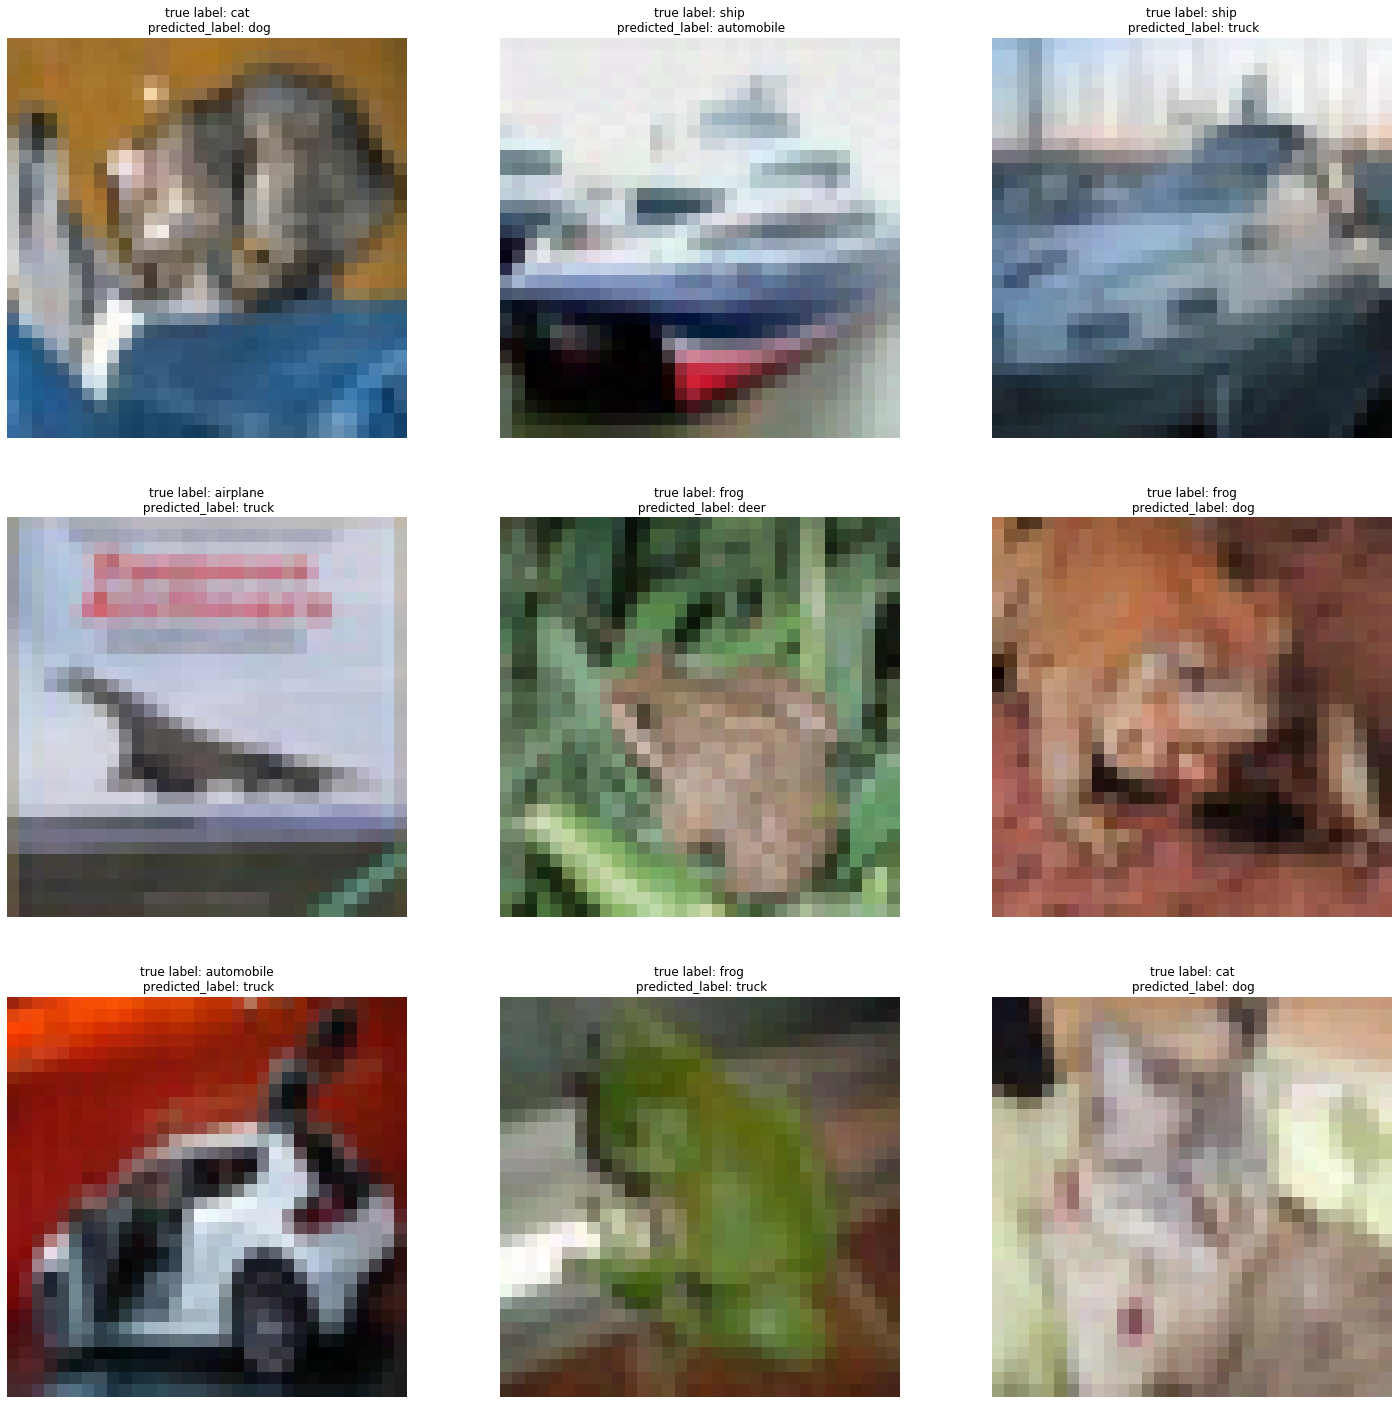

In [30]:
plt.figure(figsize=(25,25))
for i,(image, true_label) in enumerate(zip(adv_list[:9],adv_true_label[:9])): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    predicted_label=dict_classes[np.argmax(model_effnet.predict(np.expand_dims(image,axis=0)))]
    true_label=dict_classes[np.argmax(true_label)]
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_label))
    plt.axis("off")

ImageNet (déjà entrainé sur le train set) va être entrainé sur les exemples adverses. A chaque époque on eregistre une version du reseau, ce qui fait qu'on obtient 15 versions du réseaux plus ou moins familières avec les exemples adverses

In [ ]:
model_checkpoint_callback= ModelCheckpoint(filepath='/media/hdd1/benchmark_adversarial_attacks/weights.{epoch:d}.hdf5', 
                          monitor='val_loss', 
                          verbose=1, 
                          save_best_only=False, 
                          save_weights_only=True, 
                          mode='auto', save_freq='epoch')

history=model_effnet.fit(adv_train_set,
                 adv_train_label,
                 epochs=15,
                 batch_size = 128,
                 shuffle=True,
                 verbose=1,
                 callbacks=[model_checkpoint_callback])

    
    

#### Test des modèles

In [15]:
model_accuracy={}
attack_success_rate={}

model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')

y_adv_pred=list(map(np.argmax,model_effnet.predict(adv_test_set)))
y_adv_true=list(map(np.argmax,adv_test_label))
success_rate=np.sum([1 for i in range(len(y_adv_pred)) if y_adv_pred[i]!=y_adv_true[i]])/len(y_adv_pred)

y_pred=list(map(np.argmax,model_effnet.predict(X_test[5000:])))
y_true=list(map(np.argmax,y_test[5000:]))
accuracy=np.sum([1 for i in range(len(y_pred)) if y_pred[i]==y_true[i]])/len(y_pred)               
  
model_accuracy[0]=accuracy
attack_success_rate[0]=success_rate

for val in tqdm(range(1,16)):       
    model_effnet.load_weights('/media/hdd1/benchmark_adversarial_attacks/weights.'+str(val)+'.hdf5')   
    y_adv_pred=list(map(np.argmax,model_effnet.predict(adv_test_set)))
    y_adv_true=list(map(np.argmax,adv_test_label))
    success_rate=np.sum([1 for i in range(len(y_adv_pred)) if y_adv_pred[i]!=y_adv_true[i]])/len(y_adv_pred)

    y_pred=list(map(np.argmax,model_effnet.predict(X_test[5000:])))
    y_true=list(map(np.argmax,y_test[5000:]))
    accuracy=np.sum([1 for i in range(len(y_pred)) if y_pred[i]==y_true[i]])/len(y_pred)               

    model_accuracy[val]=accuracy
    attack_success_rate[val]=success_rate

100%|██████████| 15/15 [01:52<00:00,  7.52s/it]


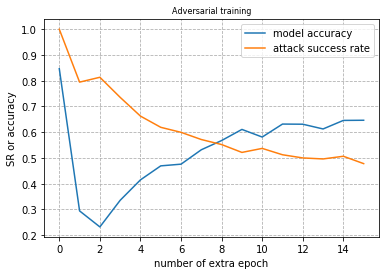

In [31]:
plt.plot(list(model_accuracy.keys()),list(model_accuracy.values()),label='model accuracy')
plt.plot(list(attack_success_rate.keys()),list(attack_success_rate.values()),label='attack success rate')
plt.grid(True,which="both", linestyle='--')
plt.title('Adversarial training', fontsize=8)
plt.xlabel('number of extra epoch')
plt.ylabel('SR or accuracy')
plt.legend(loc='upper right')
plt.show()

### Attaques 'from scratch'

In [6]:
def attack_performances_computer(model_to_fool,attack, image_list, labels,epsilon):
    model_to_fool = TensorFlowModel(model_to_fool, bounds=(0, 255))
    success=[]
    adv_list=[]
    attack_value=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        success.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
        prediction=model_effnet.predict(np.expand_dims(clipped[0][0],axis=0))           
        attack_value+=[np.argmax(prediction)]
    DOC_attack=DOC(adv_list,image_list)
    SR_attack=succes_rate(success)
    return(SR_attack)

y_true=list(map(np.argmax,y_test))

In [8]:
attack_from_scratch_success_rate={}
attack_FGSM=LinfFastGradientAttack()
y_true=list(map(np.argmax,y_test))

model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
SR=attack_performances_computer(model_effnet,attack_FGSM, X_test[5000:6000], y_true[5000:6000],[0.01])
attack_from_scratch_success_rate[0]=SR
for val in tqdm(range(1,16)):       
    model_effnet.load_weights('/media/hdd1/benchmark_adversarial_attacks/weights.'+str(val)+'.hdf5')   
    SR=attack_performances_computer(model_effnet,attack_FGSM, X_test[5000:6000], y_true[5000:6000],[0.01])
    attack_from_scratch_success_rate[val]=SR
   

W0119 09:40:20.649305 140718804559680 deprecation.py:323] From /home/timotheerio/.local/lib/python3.6/site-packages/foolbox/models/tensorflow.py:13: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
100%|██████████| 15/15 [2:15:46<00:00, 543.10s/it]


In [9]:
# with open('data/attack_from_scratch', 'wb') as f:
#     pickle.Pickler(f).dump(attack_from_scratch_success_rate)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


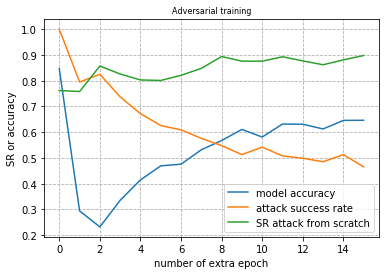

In [17]:
plt.plot(list(model_accuracy.keys()),list(model_accuracy.values()),label='model accuracy')
plt.plot(list(attack_success_rate.keys()),list(attack_success_rate.values()),label='attack success rate')
plt.plot(list(attack_from_scratch_success_rate.keys()),list(attack_from_scratch_success_rate.values()),label='SR attack from scratch')
plt.grid(True,which="both", linestyle='--')
plt.title('Adversarial training', fontsize=8)
plt.xlabel('number of extra epoch')
plt.ylabel('SR or accuracy')
plt.legend(loc='lower right')
plt.show()